In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'tss_cage_pr_curve',
        root = '..',
        default_wildcards={'sample': 'K562'}
    )

In [2]:
import pyranges as pr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from lapa import read_tss_cluster

In [3]:
dataset = snakemake.wildcards['sample']
df_config = pd.read_csv('data/results/lapa/wg_config.csv')

df_lr = snakemake.params['df_lr']
samples = df_lr[df_lr['sample'] == dataset].index.tolist()

datasets = list(set(df_config[df_config['sample'].isin(samples)].dataset))

In [4]:
from lapa.result import LapaTssResult

lapa = LapaTssResult(snakemake.input['tss_dir'], replicated=False)

Read all clusters not filtered for replication of dataset:

In [5]:
_core_cols = ['Chromosome', 'Start', 'End', 'Strand']

df_cluster = pd.concat([
    lapa.read_sample(i).drop_duplicates(_core_cols)
    for i in samples
], axis=0).reset_index().groupby([*_core_cols, 'name'], observed=True).agg('sum').reset_index()

gr_tss = pr.PyRanges(df_cluster, int64=True)

Read CAGE or Rampage grouth truth

In [6]:
df_true = pd.concat([
    pd.read_csv(i, sep='\t', header=None)
    .rename(columns={0: 'Chromosome', 1: 'Start', 2: 'End', 5: 'Strand'})
    for i in snakemake.input['bed']
])
df_true = df_true[(df_true[4] > 540)] # 540 means `IDR < 0.05`

gr_true = pr.PyRanges(df_true[['Chromosome', 'Start', 'End', 'Strand']], int64=True)

In [7]:
import numpy as np

if snakemake.input['other_bed']:
    df_other = pd.concat([
        pd.read_csv(i, sep='\t', header=None)
        .rename(columns={0: 'Chromosome', 1: 'Start', 2: 'End', 5: 'Strand', 4: 'score'})
        for i in snakemake.input['other_bed']
    ]).drop_duplicates(_core_cols)
    
    gr_other = pr.PyRanges(df_other[['Chromosome', 'Start', 'End', 'Strand', 'score']], int64=True)

In [8]:
gr = gr_tss.join(gr_true, strandedness='same', suffix='_true', how='outer', slack=100)
gr = gr[gr.Chromosome.str.startswith('chr')]
gr = gr.df
gr = gr[(gr.Start != -1) | (gr.Start_true != -1)] # bug in pyranges?

/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/

/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/

/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/

In [9]:
if snakemake.input['other_bed']:
    gr_other = gr_other.join(gr_true, strandedness='same', suffix='_true', how='outer', slack=100)
    gr_other = gr_other[gr_other.Chromosome.str.startswith('chr')]
    gr_other = gr_other.df
    gr_other = gr_other[(gr_other.Start != -1) | (gr_other.Start_true != -1)] # bug in pyranges?

/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/

/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/

/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/

/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)


Calculate number of replicated clusters

In [12]:
#lapa.read_dataset(dataset)['count'].min()
from more_itertools import flatten

replicated = set(flatten([
    lapa.read_dataset(i).index
    for i in datasets
]))

cutoff = df_cluster[df_cluster['name'].isin(replicated)]['count'].min()

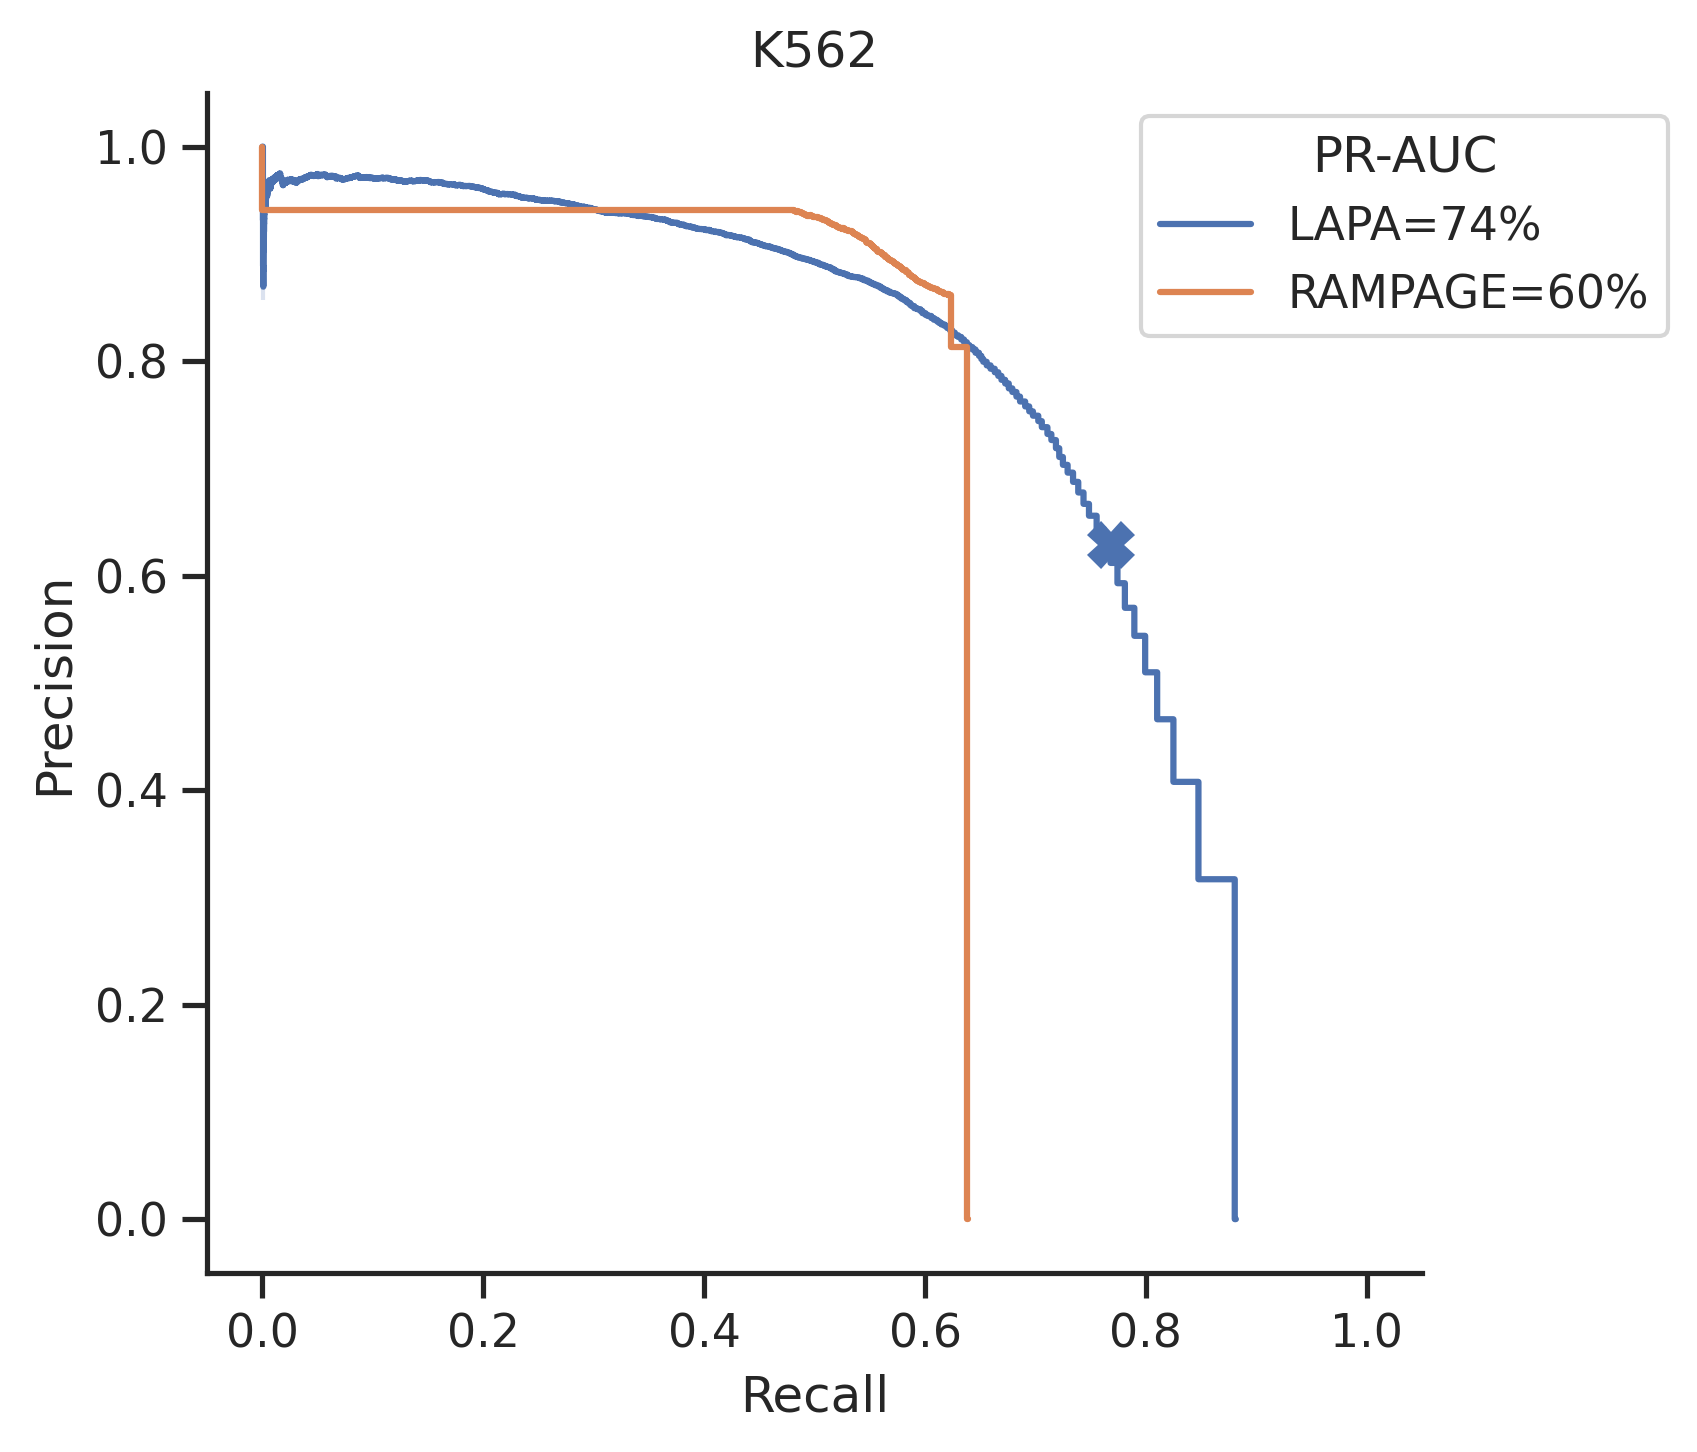

In [13]:
plt.figure(figsize=(5, 5), dpi=300)

from sklearn.metrics import auc, precision_recall_curve, roc_curve

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Plot long-reads
ground_truth = list((gr.Start_true != -1).astype(int))
score = list(gr['count'].replace(-1, 0))

prec, recall, threshold = precision_recall_curve(
    ground_truth, score, pos_label=1)
prec[0] = 0
recall[0] = recall[1] + 0.001
# If no prediction set precision to zero at the recall for ploting
# consistant with `steps-pre` prediciton

df_benchmark = pd.DataFrame({
    'data source': f'LAPA={int(auc(recall, prec) * 100)}%',
    'Precision': prec,
    'Recall': recall,
    'threshold': [0] + threshold.tolist()
})

df_benchmark['replicated'] = df_benchmark['threshold'] > cutoff
row = df_benchmark[df_benchmark['replicated']].iloc[0]
plt.plot(row['Recall'], row['Precision'], 'X', markersize=10, zorder=10)

# Save performance
df_benchmark.to_csv(snakemake.output['pr'], index=False)

# Plot other
if snakemake.input['other_bed']:
    ground_truth_other = list((gr_other.Start_true != -1).astype(int))
    score_other = list(gr_other.score.replace(-1, 0))

    prec_other, recall_other, threshold_other = precision_recall_curve(
        ground_truth_other, score_other, pos_label=1)
    prec_other[0] = 0
    recall_other[0] = recall_other[1] + 0.001

    df_benchmark_other = pd.DataFrame({
        'data source': f'{snakemake.params["other_label"]}={int(auc(recall_other, prec_other) * 100)}%',
        'Precision': prec_other,
        'Recall': recall_other,
        'threshold': [0] + threshold_other.tolist()
    })
    
    df_benchmark = pd.concat([
        df_benchmark,
        df_benchmark_other        
    ], axis=0).reset_index(drop=True)

plt.title(dataset)
sns.lineplot(data=df_benchmark, y='Precision', x='Recall', hue='data source', drawstyle='steps-pre')

plt.legend()._legend_box.align='right'

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.tight_layout()
plt.legend(bbox_to_anchor=(0.75, 1.), loc='upper left', title='PR-AUC')
plt.savefig(snakemake.output['fig'], bbox_inches = "tight")